In [3]:
#Imports
import numpy as np
import scipy as sp
import pandas as pd
import psycopg2
import math
from numpy import array, empty
import warnings
import datetime
import lifetimes
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.cross_validation import train_test_split
import copy
from lifelines.utils import concordance_index
from matplotlib import pyplot as plt
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
%matplotlib inline
warnings.filterwarnings('ignore')
import pyrothko as rk

def shuffle(df, n=1, axis=0):     
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df

def myround(x, prec=2, base=.05):
  return round(base * round(float(x)/base),prec)

def flatten(l):
    return [item for sublist in l for item in sublist]


strToDateTime = lambda x: pd.tslib.Timestamp(x).to_datetime()

# cell 2: connection
conn = psycopg2.connect(
   database='belkin',
   port=os.environ['REDSHIFT_PORT'],
   password=os.environ['REDSHIFT_PASS'],
   user=os.environ['REDSHIFT_USER'],
   host=os.environ['REDSHIFT_HOST']
  ) 

In [4]:
query = """
SELECT location,
       modelcode,
       device,
       actuation_f.macaddress AS mac,
       DATE (datets) AS DATE,
       DATE_PART('hour',datets) AS hour,
       COUNT(1) AS acts
FROM actuation_f
  INNER JOIN ((SELECT d1.macaddress AS mac,
                     w.modelcode,
                     location,
                     device,
                     MAX(DATE) AS last_usage_date,
                     COUNT(1)
              FROM (SELECT macaddress,
                           DATE (datets) AS DATE,
                           DATE_PART('hour',datets) AS HOUR,
                           COUNT(1) AS acts
                    FROM actuation_f
                    WHERE LOWER (actuatedby) LIKE '%manual%'
                    GROUP BY macaddress,
                             DATE (datets),
                             DATE_PART('hour',datets)) AS d1
                LEFT JOIN wemo_d AS w ON w.macaddress = d1.macaddress
                LEFT JOIN ds_custom_name_annotations AS ds ON ds.wemoid = w.pluginid
              WHERE w.modelcode = 'Socket'
              GROUP BY d1.macaddress,
                       w.modelcode,
                       location,
                       device 
              LIMIT 10000)
              UNION
              (SELECT d1.macaddress AS mac,
                     w.modelcode,
                     location,
                     device,
                     MAX(DATE) AS last_usage_date,
                     COUNT(1)
              FROM (SELECT macaddress,
                           DATE (datets) AS DATE,
                           DATE_PART('hour',datets) AS HOUR,
                           COUNT(1) AS acts
                    FROM actuation_f
                    WHERE LOWER (actuatedby) LIKE '%manual%'
                    GROUP BY macaddress,
                             DATE (datets),
                             DATE_PART('hour',datets)) AS d1
                LEFT JOIN wemo_d AS w ON w.macaddress = d1.macaddress
                LEFT JOIN ds_custom_name_annotations AS ds ON ds.wemoid = w.pluginid
              WHERE w.modelcode = 'Lightswitch'
              GROUP BY d1.macaddress,
                       w.modelcode,
                       location,
                       device LIMIT 10000)
              UNION
              (SELECT d1.macaddress AS mac,
                     w.modelcode,
                     location,
                     device,
                     MAX(DATE) AS last_usage_date,
                     COUNT(1)
              FROM (SELECT macaddress,
                           DATE (datets) AS DATE,
                           DATE_PART('hour',datets) AS HOUR,
                           COUNT(1) AS acts
                    FROM actuation_f
                    WHERE LOWER (actuatedby) LIKE '%manual%'
                    GROUP BY macaddress,
                             DATE (datets),
                             DATE_PART('hour',datets)) AS d1
                LEFT JOIN wemo_d AS w ON w.macaddress = d1.macaddress
                LEFT JOIN ds_custom_name_annotations AS ds ON ds.wemoid = w.pluginid
              WHERE w.modelcode = 'Insight'
              GROUP BY d1.macaddress,
                       w.modelcode,
                       location,
                       device LIMIT 10000)) AS freq_macs ON freq_macs.mac = actuation_f.macaddress
WHERE lower (actuatedby) LIKE '%manual%'
AND   datediff (days,DATE (datets),DATE ('2016-08-27')) < 14
GROUP BY location,
         modelcode,
         device,
         actuation_f.macaddress,
         DATE (datets),
         DATE_PART('hour',datets)





     
        
"""        
df = pd.read_sql(query, conn)
df = df.sort(['mac','date','hour'], ascending = True)
df['ts'] = df.apply(lambda x: datetime.datetime(x['date'].year, x['date'].month, x['date'].day,int(x['hour'])),axis=1)

In [5]:
q='''
select 
macaddress, max(case when actuatedby like '%TimeRule%' then 1 else 0 end) as used_timerule

from actuation_f
group by macaddress

'''
used_timerule = pd.read_sql(q, conn)

In [6]:
def explodeDataFrameHours(df, ordering_col, id_col, event_col , fill_missing_with=0):
    extrema = df.groupby(id_col)[ordering_col].agg({'first':np.min, 'last':np.max})[['first','last']]
    ints = map(lambda x: pd.date_range(start=x[0],end=x[1], freq='h'), extrema.values)
    zipped_ints = [[(pair[0], date_value) for date_value in pair[1].values] for pair in zip(extrema.index.values, ints)]
    index = pd.DataFrame(flatten(zipped_ints), columns = [id_col, ordering_col])
    result = index.set_index([id_col, ordering_col])
    to_join = df.groupby([id_col, ordering_col])[event_col].sum()
    result[event_col] = to_join
    result[event_col] = result[event_col].fillna(fill_missing_with)
    return result

def explodeDataFrameDate(df, ordering_col, id_col, event_col , fill_missing_with=0):
    extrema = df.groupby(id_col)[ordering_col].agg({'first':np.min, 'last':np.max})[['first','last']]
    ints = map(lambda x: pd.date_range(start=x[0],end=x[1], freq='D'), extrema.values)
    zipped_ints = [[(pair[0], date_value) for date_value in pair[1].values] for pair in zip(extrema.index.values, ints)]
    index = pd.DataFrame(flatten(zipped_ints), columns = [id_col, ordering_col])
    result = index.set_index([id_col, ordering_col])
    to_join = pd.DataFrame(df.groupby([id_col, ordering_col])[event_col].sum()).reset_index()
    to_join[ordering_col] = pd.to_datetime(to_join[ordering_col])
    to_join.set_index([id_col, ordering_col], inplace = True)
    result[event_col] = to_join
    result[event_col] = result[event_col].fillna(fill_missing_with)
    return result

def cond_count(x):
    if x['first_actuation']== True:
        cond_count.last_count =0
    else:
        inactive = x['inactive']
        if inactive == 0:
            cond_count.last_count = 0
        else:
            cond_count.last_count += 1
    return cond_count.last_count
cond_count.last_count = 0

In [7]:
id_col = 'mac'
ordering_col = 'ts'
event_col = 'acts'
z = explodeDataFrameHours(df, ordering_col, id_col, event_col).reset_index()

In [8]:
z['hour'] = z.ts.apply(lambda x: x.hour)
z['hour_number'] = z.groupby('mac').cumcount()

In [9]:
z['last_actuation'] = z.mac != z.mac.shift(-1)
z['first_actuation'] = z.mac != z.mac.shift(1)

In [10]:
z['inactive'] = (z.acts==0).map({True:1, False:0})
z['was_inactive'] = z['inactive'].shift()

In [11]:
z['was_inactive'][z.first_actuation==True] = np.nan
z['periods_ianctive'] = z.apply(lambda x: cond_count(x), axis = 1)

In [13]:
z['hour_number'] = z.groupby('mac').cumcount()
z['period_shift'] = z.inactive != z.was_inactive

In [14]:
z['period_shift'] = z.groupby('mac')['period_shift'].cumsum()

In [15]:
#empty cell

In [16]:
from statsmodels.tsa import stattools

mac_addresses = list(set(z.mac))
acfs = {}
sigs = {}

lag_hours = 24 * 7


for mac in mac_addresses:
    counts = z[z.mac==mac].acts
    if len(counts)>lag_hours:
        acfs[mac], sig = stattools.acf(counts, nlags=lag_hours, alpha = .05)
        sig_level = np.apply_along_axis(lambda x: np.equal(*np.sign(x)) and x[1] > 0, 1, sig)
        sigs[mac] = sig_level
    else:
        acfs[mac] = np.nan
        sigs[mac] = np.nan
acfs = pd.DataFrame(acfs)
acfs = acfs.T
sigs = pd.DataFrame(sigs).T

In [17]:
#bookmark

In [18]:
def format_chart(ax,loc=None, horizontal=False):
    """A function to format matplotlib charts top look more rothko-esque
    Can take in a single axis or a list of axes and format each chart. Build your chart
    and then run format_chart() right before plt.show().
    
    Some notes:
    You can pass it a single axis object or a list/tuple/array of axis objects and the 
    function will format them all the same way according to your specifications
    
    If you use plt to manipulate your charts, you have to pass an axis object. Do so
    by passing the function plt.gca().
    
    loc handles the legend. Default is to always include a legend. You can either specify
    a legend location with an integer 0-8 or no legend with loc=False.
    
    horizontal = True is for horizontally oriented charts"""
    
    def formater(ax,horizontal = horizontal, loc=None):
        
        if horizontal:
            #determine the visible spines/ticks and where grids should be
            visible_spines = ['top','bottom','right']
            grid_orientation = ax.xaxis
        else:
            visible_spines = ['top','left','right']
            grid_orientation = ax.yaxis

        #remove spines
        for spine in visible_spines:
            ax.spines[spine].set_visible(False)

        #remove excess ticks
        ax.xaxis.set_tick_params(which='both',top= False if 'top' in visible_spines else True
                                 , bottom = False if 'bottom' in visible_spines else True)
        ax.yaxis.set_tick_params(which='both',left= False if 'left' in visible_spines else True
                                 , right = False if 'right' in visible_spines else True)
        #grids
        ax.grid(False)
        grid_orientation.grid(True)
                
        #white background
        ax.set_axis_bgcolor('w')

        #change legend frame
        if loc != None:
            _loc = loc
        else:
            _loc = 0
        
        if loc != False:
            ax.legend(frameon=False,loc = _loc)    

        return ax

    
    #if list of axes, iterate through the list
    if type(ax) == list:
        new_ax = [formater(x,horizontal,loc) for x in ax]
    else:        
        new_ax = formater(ax,horizontal,loc)

    return new_ax

This post seeks to answer the following question:
>Can we identify users who are likely candidates for time rules?

This post examines the population of users who do not use WeMo's scheduling features, yet use their device manually on a schedule. We introduce our methodology for identifying those users, and explore the types of devices they use with their WeMo products based on custom names.


### Key Findings
* Approximately 10-15% of users manually actuate their Switches, Insights, or Lightswitches consistently on a daily cycle.
* Of those users, only 40-45% have ever used time rules to actuate their devices.
* Devices in bedrooms are the most likely to be manually actuated on 24-hour cycles.
* Of devices plugged in to Switches, coffee makers are the most likely to be manually actuated on 24-hour cycles.

### Limitations
In this post, we do not consider a user's full actuation history; rather we take the last 2 weeks of their actuation data such that our findings reflect users' most recent habits. Manual actuations are examined based on hourly counts.

### Identifying Common Actuation Schedules

To determine whether actuation patterns are cyclical, we conduct statistical hypothesis tests to evaluate whether a user's actuations are significantly correlated with previous actuations for a given interval.

For instance, if a user's actuation frequency at 12:00 PM is significantly correlated with their behavior at 5:00 AM, we conclude that the user actuates their device on a 6 hour cycle. If a device is used on both a 6 hour and 12 hour cycle, we simplify by stating the user is on a 6 hour cycle, as the 12 hour cycle is encompassed by the 6 hour cycle.

Below, we plot the strength of correlation in behavior at different time intervals.

The plot below illustrates the average autocorrelation between a user's actuations at a given time and their actuations t hours ago:

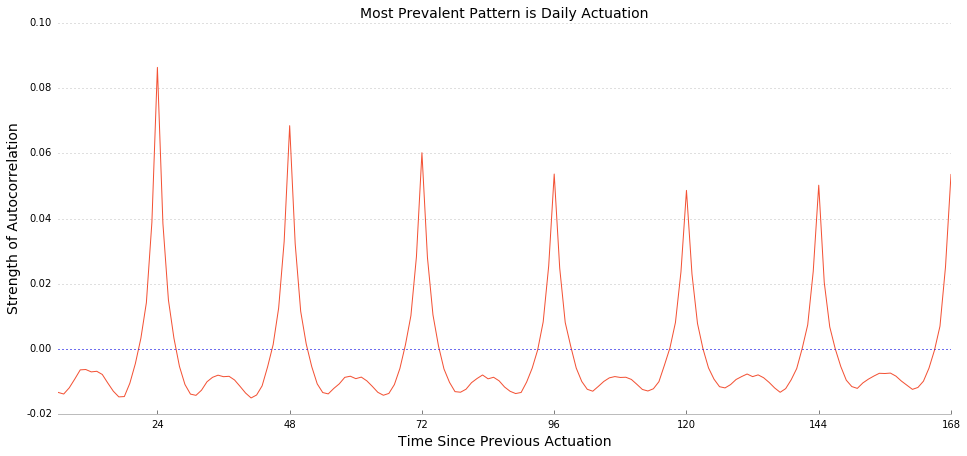

In [19]:
plt.rcParams['figure.figsize'] = (16, 7)
ax = acfs.mean().iloc[6:].plot()
ax.set_xticks([i*24 for i in range(1, 8)])
ax.set_xlabel("Time Since Previous Actuation")
ax.set_ylabel("Strength of Autocorrelation")
ax.set_title("Most Prevalent Pattern is Daily Actuation")
ax.axhline(0, linestyle = ":")
format_chart(plt.gca())
ax.legend_.remove()
plt.show()


We find that there are strong daily cycles of actuation patterns. While there are longer cycles, some cases of having 48 or 72 cycles may simply be artifacts of having a 24 hour cycle. Therefore, for each user with compute the strongest single cyclic pattern. For instance, if a user's 24 hour autocorrelation is .1 and their 48 hour autocorrelation function is .08, then we would determine that the strongest cycle for that user is 24 hours. We plot the frequency of strongest cycles below.

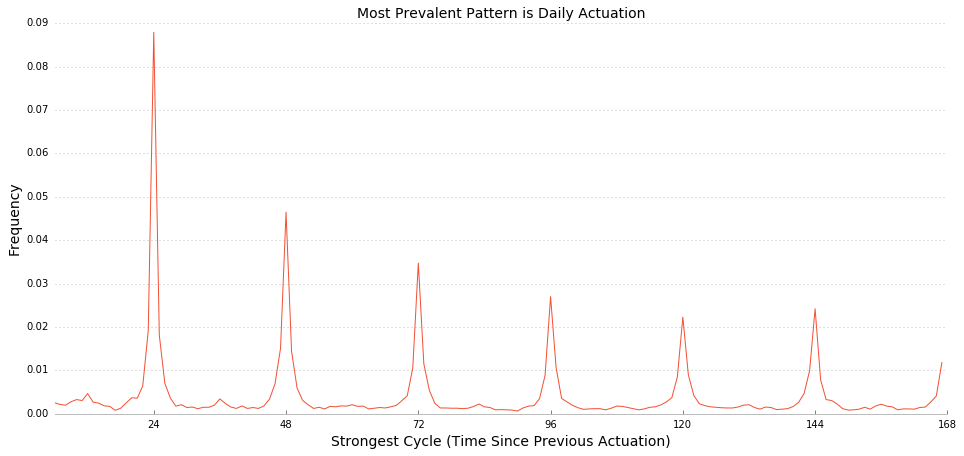

In [20]:
plot_data = acfs[range(1, lag_hours)].T.idxmax().value_counts().loc[range(6, lag_hours)]
plot_data
plot_data = plot_data / sigs.shape[0]
ax = plot_data.plot()
ax.set_xticks([i*24 for i in range(1, 8)])
ax.set_xlabel("Strongest Cycle (Time Since Previous Actuation)")
ax.set_ylabel("Frequency")
ax.set_title("Most Prevalent Pattern is Daily Actuation")
ax.axhline(0, linestyle = ":")
format_chart(plt.gca())
ax.legend_.remove()
plt.show()

Our final step is to determine whether each user's strongest cycle is statistically significant (i.e. whether the results are significant enough to not be attributed to random chance). The plot below illustrates the frequency of statistically significant strongest cycles.

In [21]:


def conditional_idxmax(row):
    if pd.isnull(max(row))==True:
        return 'No Sig Cycle'
    elif max(row) == False:
        return 'No Sig Cycle'
    else:
        return np.argmax(row)

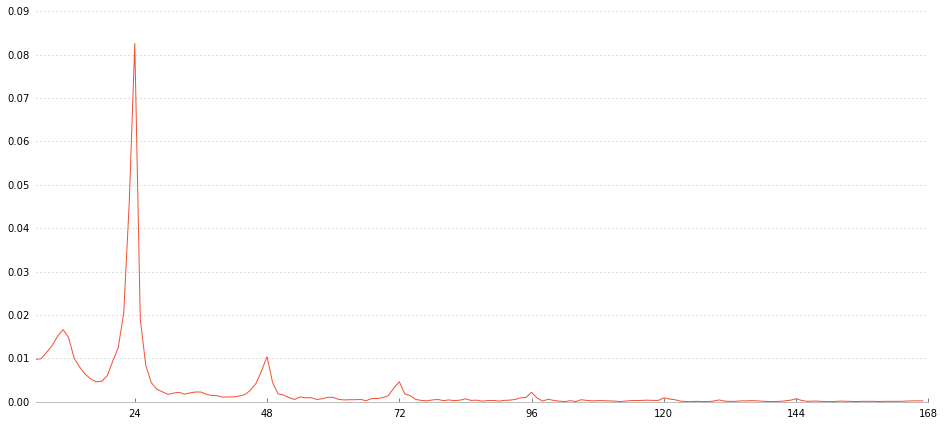

In [22]:
plot_data = sigs[range(1, lag_hours)].apply(lambda x: conditional_idxmax(x),axis=1).value_counts().sort_index().iloc[5:-1]
plot_data = plot_data / sigs.shape[0]
ax = plot_data.plot()
ax.set_xticks([i*24 for i in range(1, 8)])
format_chart(plt.gca())
ax.legend_.remove()
plt.show()

Most of the observed multi-day patterns are either insignificant or are artifacts of daily use, though there are a small number of users that exhibit 2-3 day cycles of usage. Overall, 24-hour cycles are the most common, with 10-15% of users actuating on this schedule.

In [23]:
cycle_data = sigs[range(1, lag_hours)].apply(lambda x: conditional_idxmax(x),axis=1)
mac_addresses_of_daily_users = cycle_data[cycle_data==24].index.values

### Users with Daily Cycles

Prevalence of daily manual actuation cycles varies between device types and locations. Bedrooms have the highest percentage of devices that follow 24-hour manual cycles. This is especially pronounced for Insights, as 19% of bedroom insights are actuated on 24-hour cycles. By contrast, outdoor Insights and Switches are the least-often actuated on 24-hour manual cycles, at 6% and 10%, respectively. Interestingly, this does not apply to outdoor Lightswitches; 17% of these devices are actuated on manual 24-hour cycles.

In [24]:
append_data = df.groupby(['mac','modelcode','location'])['date'].count().reset_index().drop('date',1).set_index('mac')
append_data['cycle'] = cycle_data
append_data['has_24_hour_cycle'] = append_data.cycle.apply(lambda x: x in (23,24,25))


In [25]:
def name_cleaner(name):
    clean_dict = {'living-room':'Living Room',
                  'other-space':'Other Location',
                  'office':'Office',
                  '':'Unknown Location',
                  'outdoor':'Outdoor',
                  'bedroom':'Bedroom',
                  'kitchen':'Kitchen',
                  'socket':'Switch'}
                  
    if name in clean_dict.keys():
                  return clean_dict[name]
    else: return name
    

In [26]:
plot_data = append_data.groupby(['modelcode','location'])['has_24_hour_cycle'].mean().unstack().drop('other-language',1)
order = plot_data.mean().sort_values().index.values
plot_data = plot_data[order]

In [27]:
jmdf_2 = plot_data.T * 100
jmdf = jmdf_2.copy()
jmdf.index = jmdf.index.map(name_cleaner)

In [28]:
#jmdf = jmdf.unstack().unstack()
jmdf

modelcode,Insight,Lightswitch,Socket
Office,6.542056,15.706806,10.169492
Outdoor,6.153846,17.289459,9.629630
Unknown Location,12.112542,16.539440,12.624357
Other Location,12.275449,14.027630,15.025907
Kitchen,10.243902,16.306954,16.666667
Living Room,13.712544,14.117647,17.427386
Bedroom,19.085487,18.319838,18.386492


In [29]:
rk.plot(jmdf, kind = 'bar',
        title='Users who Exhibit Strong Daily Manual Actuation Patterns',
        ylabel='Percentage of Devices in Location')

In [30]:
query = """
SELECT location,
       modelcode,
       device,
       actuation_f.macaddress AS mac,
       DATE (datets) AS DATE,
       DATE_PART('hour',datets) AS hour,
       COUNT(1) AS acts
FROM actuation_f
  INNER JOIN ((      SELECT d1.macaddress AS mac,
                     w.modelcode,
                     location,
                     device,
                     MAX(DATE) AS last_usage_date,
                     COUNT(1)
              FROM (SELECT macaddress,
                           DATE (datets) AS DATE,
                           DATE_PART('hour',datets) AS HOUR,
                           COUNT(1) AS acts
                    FROM actuation_f
                    WHERE LOWER (actuatedby) LIKE '%manual%'
                    GROUP BY macaddress,
                             DATE (datets),
                             DATE_PART('hour',datets)) AS d1
                LEFT JOIN wemo_d AS w ON w.macaddress = d1.macaddress
                LEFT JOIN ds_custom_name_annotations AS ds ON ds.wemoid = w.pluginid
              WHERE device <> '' and device <> 'light'
              GROUP BY d1.macaddress,
                       w.modelcode,
                       location,
                       device
                       
                       )
                UNION       
                      (      SELECT d1.macaddress AS mac,
                     w.modelcode,
                     location,
                     device,
                     MAX(DATE) AS last_usage_date,
                     COUNT(1)
              FROM (SELECT macaddress,
                           DATE (datets) AS DATE,
                           DATE_PART('hour',datets) AS HOUR,
                           COUNT(1) AS acts
                    FROM actuation_f
                    WHERE LOWER (actuatedby) LIKE '%manual%'
                    GROUP BY macaddress,
                             DATE (datets),
                             DATE_PART('hour',datets)) AS d1
                LEFT JOIN wemo_d AS w ON w.macaddress = d1.macaddress
                LEFT JOIN ds_custom_name_annotations AS ds ON ds.wemoid = w.pluginid
              WHERE device <> '' and device <> 'light'
              GROUP BY d1.macaddress,
                       w.modelcode,
                       location,
                       device
                       
                       ) 
                       ) AS freq_macs ON freq_macs.mac = actuation_f.macaddress
WHERE lower (actuatedby) LIKE '%manual%'
AND   datediff (days,DATE (datets),DATE ('2016-08-27')) < 14
GROUP BY location,
         modelcode,
         device,
         actuation_f.macaddress,
         DATE (datets),
         DATE_PART('hour',datets)





     
        
"""        
df = pd.read_sql(query, conn)
df = df.sort(['mac','date','hour'], ascending = True)
df['ts'] = df.apply(lambda x: datetime.datetime(x['date'].year, x['date'].month, x['date'].day,int(x['hour'])),axis=1)

In [31]:
id_col = 'mac'
ordering_col = 'ts'
event_col = 'acts'
z = explodeDataFrameHours(df, ordering_col, id_col, event_col).reset_index()

In [32]:
z['hour'] = z.ts.apply(lambda x: x.hour)
z['hour_number'] = z.groupby('mac').cumcount()
z['last_actuation'] = z.mac != z.mac.shift(-1)
z['first_actuation'] = z.mac != z.mac.shift(1)
z['inactive'] = (z.acts==0).map({True:1, False:0})
z['was_inactive'] = z['inactive'].shift()
z['was_inactive'][z.first_actuation==True] = np.nan
z['periods_ianctive'] = z.apply(lambda x: cond_count(x), axis = 1)
z['hour_number'] = z.groupby('mac').cumcount()
z['period_shift'] = z.inactive != z.was_inactive
z['period_shift'] = z.groupby('mac')['period_shift'].cumsum()

In [33]:
from statsmodels.tsa import stattools

mac_addresses = list(set(z.mac))
acfs = {}
sigs = {}

lag_hours = 24 * 7


for mac in mac_addresses:
    counts = z[z.mac==mac].acts
    if len(counts)>lag_hours:
        acfs[mac], sig = stattools.acf(counts, nlags=lag_hours, alpha = .05)
        sig_level = np.apply_along_axis(lambda x: np.equal(*np.sign(x)) and x[1] > 0, 1, sig)
        sigs[mac] = sig_level
    else:
        acfs[mac] = np.nan
        sigs[mac] = np.nan
acfs = pd.DataFrame(acfs)
acfs = acfs.T
sigs = pd.DataFrame(sigs).T

In [34]:
cycle_data = sigs[range(1, lag_hours)].apply(lambda x: conditional_idxmax(x),axis=1)
mac_addresses_of_daily_users = cycle_data[cycle_data==24].index.values

append_data = df.groupby(['mac','modelcode','device'])['date'].count().reset_index().drop('date',1).set_index('mac')
append_data['cycle'] = cycle_data
append_data['has_24_hour_cycle'] = append_data.cycle.apply(lambda x: x in (23,24,25))


Percentages of users who actuate manually on 24-hour cycles also differs by the kind of device plugged in to WeMo Switches. Electric blankets and coffee makers are the most commonly actuated on 24-hour cycles, at 18-19% of the time. This is likely due to these devices' place in daily routines, i.e. during sleep and immediately after waking up. Fans, AC units, and heaters are less likely to be actuated on 24-hour cycles, but are more commonly actuated on 10 to 12-hour cycles, possibly corresponding to users' work schedules.

In [ ]:
common_devices = append_data.device.value_counts()[append_data.device.value_counts() > 75].index.values
plot_data = append_data.groupby('device')['has_24_hour_cycle'].mean().loc[common_devices].sort_values(ascending = False)

In [39]:
final_df = plot_data.copy()
final_df = final_df * 100
final_df

device
Electric Blanket           18.823529
Coffee Maker               17.537943
Kettle                     15.887850
Water Heater               11.627907
TV                         10.645724
Fan                        10.366329
Heater                      9.931507
AC                          9.467456
christmas/outdoor light     9.055338
Music                       8.620690
Camera                      4.020101
Name: has_24_hour_cycle, dtype: float64

In [43]:
rk.plot(final_df,
        title='Switch Users who Exhibit Daily Manual Actuation Patterns',
        xlabel = 'Plugged-in Device',
        ylabel='Percentage of Users with Daily Usage Pattern')

### Impact and Further Opportunities

This post explored the prevalence of repeated cycles of manual device actuations, with the intent of determining the viability of recommending rules based on these patterns. 24-hour cycles are common, with some device subsets utilizing them up to 19% of the time.

Of the users on 24-hour cycles, only 40-45% have ever used time rules. Because these users are using manual actuations in a pattern that lends itself to time rules, the value they are extracting from their devices could potentially be enhanced by recommending rules. This could be done via enhancements to the app, e.g. implementation of push notifications based on patterns. This analysis is also valuable as a measurement of overall use/disuse of time rules in situations where they would be helpful. Future analyses can examine the viability of recommending other rule types based on behavioral patterns.